<a href="https://colab.research.google.com/github/AnalyticalHarry/AB-Testing/blob/main/Nvidia_Call_Option_16_June_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [4]:
call_option = pd.read_excel('nvidia_calls.xlsx')
call_option

,Exp. Date,Last,Change,Bid,Ask,Volume,Open Int.,Strike
0,2024-06-14,124.40,6.81,125.25,126.40,71,288,1095.0
1,2024-06-14,121.45,2.43,120.50,122.00,520,3303,1100.0
2,2024-06-14,110.60,1.35,116.25,117.40,59,401,1105.0
3,2024-06-14,112.00,1.70,111.80,112.95,139,2384,1110.0
4,2024-06-14,97.34,-9.03,107.50,108.60,1043,812,1115.0
5,2024-06-14,100.95,-2.25,103.10,104.35,267,1741,1120.0
6,2024-06-14,91.15,-7.00,99.00,100.00,985,674,1125.0
7,2024-06-14,95.00,1.80,94.85,95.75,145,9780,1130.0
8,2024-06-14,87.55,-1.85,89.60,90.65,58,842,1135.0
9,2024-06-14,85.10,-1.04,85.65,86.65,243,7039,1140.0


In [5]:
ticker = yf.Ticker("NVDA")
current_price = ticker.history(period="1d")['Close'].iloc[-1]
current_price

1208.8800048828125

**Why Is the U.S. 3-Month T-Bill Used as the Risk-Free Rate?**

There can never be a truly risk-free rate because even the safest investments carry a very small amount of risk. However, the interest rate on a three-month U.S. Treasury bill is often used as the risk-free rate for U.S.-based investors. This is a useful proxy because the market considers there to be virtually no chance of the U.S. government defaulting on its obligations. The large size and deep liquidity of the market contribute to the perception of safety.

In [6]:
def historical_data(ticker_symbol, period):
    ticker = yf.Ticker(ticker_symbol)
    if period.endswith('d'):
        period = '1mo'
    elif period.endswith('mo'):
        period = period[:-2] + 'mo'

    historical_data = ticker.history(period=period)
    historical_data['Daily_Return'] = historical_data['Close'].pct_change()
    historical_data.dropna(inplace=True)
    return historical_data

def volatility(data, trading_days_per_year):
    vol = data['Daily_Return'].std() * np.sqrt(trading_days_per_year)
    return vol

def main():
    ticker_symbol = 'NVDA'
    periods = ['5d', '10d', '20d', '30d', '1mo', '3mo', '6mo', '1y']
    for period in periods:
        data = historical_data(ticker_symbol, period)

        if period.endswith('d'):
            trading_days_per_year = 252
        elif period.endswith('mo'):
            months = int(period[:-2])
            trading_days_per_year = 21 * months
        else:
            trading_days_per_year = 252

        vol = volatility(data, trading_days_per_year)
        print(f"Historical Volatility for {ticker_symbol} ({period}):", vol)

In [7]:
main()

Historical Volatility for NVDA (5d): 0.499323231183347
Historical Volatility for NVDA (10d): 0.499323231183347
Historical Volatility for NVDA (20d): 0.499323231183347
Historical Volatility for NVDA (30d): 0.499323231183347
Historical Volatility for NVDA (1mo): 0.14414220096816954
Historical Volatility for NVDA (3mo): 0.2561136758482956
Historical Volatility for NVDA (6mo): 0.35175388364964827
Historical Volatility for NVDA (1y): 0.4426483900295145


In [8]:
volatility = 0.141
risk_free_rate = 0.0525
epsilon = 1e-9

In [9]:
def d1_d2(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate):
    time_to_expiry = max(time_to_expiry, epsilon)
    d1 = (np.log(stock_price / strike_price) + (real_risk_free_rate + 0.5 * volatility**2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    return d1, d2

In [10]:
def delta(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate):
    d1, _ = d1_d2(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate)
    return norm.cdf(d1)

In [11]:
def gamma(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate):
    d1, _ = d1_d2(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate)
    return norm.pdf(d1) / (stock_price * volatility * np.sqrt(time_to_expiry))

In [12]:
def theta(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate):
    d1, d2 = d1_d2(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate)
    term1 = -stock_price * norm.pdf(d1) * volatility / (2 * np.sqrt(time_to_expiry))
    term2 = real_risk_free_rate * strike_price * np.exp(-real_risk_free_rate * time_to_expiry) * norm.cdf(d2)
    return term1 - term2


In [13]:
def vega(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate):
    d1, _ = d1_d2(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate)
    return stock_price * norm.pdf(d1) * np.sqrt(time_to_expiry)

In [14]:
def rho(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate):
    _, d2 = d1_d2(stock_price, strike_price, time_to_expiry, volatility, real_risk_free_rate)
    return strike_price * time_to_expiry * np.exp(-real_risk_free_rate * time_to_expiry) * norm.cdf(d2)

In [15]:
current_date = pd.Timestamp.today()
call_option['Exp. Date'] = pd.to_datetime(call_option['Exp. Date'])
call_option['T'] = (call_option['Exp. Date'] - current_date).dt.days / 365.0

In [16]:
call_option['Delta'] = call_option.apply(lambda row: delta(current_price, row['Strike'], row['T'], volatility, risk_free_rate), axis=1)
call_option['Gamma'] = call_option.apply(lambda row: gamma(current_price, row['Strike'], row['T'], volatility, risk_free_rate), axis=1)
call_option['Theta'] = call_option.apply(lambda row: theta(current_price, row['Strike'], row['T'], volatility, risk_free_rate), axis=1)
call_option['Vega']  = call_option.apply(lambda row: vega(current_price, row['Strike'], row['T'], volatility, risk_free_rate), axis=1)
call_option['Rho']   = call_option.apply(lambda row: rho(current_price, row['Strike'], row['T'], volatility, risk_free_rate), axis=1)

In [17]:
call_option[['Exp. Date', 'Strike', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']]

,Exp. Date,Strike,Delta,Gamma,Theta,Vega,Rho
0,2024-06-14,1095.0,1.000000,4.182319e-09,-57.437969,0.000014,17.984472
1,2024-06-14,1100.0,1.000000,1.632446e-08,-57.700415,0.000055,18.066592
2,2024-06-14,1105.0,1.000000,5.945438e-08,-57.963304,0.000201,18.148709
3,2024-06-14,1110.0,0.999999,2.022309e-07,-58.227611,0.000685,18.230817
4,2024-06-14,1115.0,0.999997,6.430106e-07,-58.496155,0.002178,18.312897
5,2024-06-14,1120.0,0.999991,1.912837e-06,-58.776472,0.006479,18.394891
6,2024-06-14,1125.0,0.999973,5.328479e-06,-59.087214,0.018049,18.476652
7,2024-06-14,1130.0,0.999924,1.391117e-05,-59.471097,0.047120,18.557811
8,2024-06-14,1135.0,0.999804,3.406620e-05,-60.018465,0.115390,18.637522
9,2024-06-14,1140.0,0.999520,7.831433e-05,-60.905426,0.265268,18.713975


In [18]:
def plot_greeks(call_option):
    fig, axs = plt.subplots(3, 2, figsize=(14, 14), facecolor='black')

    for ax in axs.flat:
        ax.set_facecolor('black')
        ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

    axs[0, 0].plot(call_option['Strike'], call_option['Delta'], color='lime')
    axs[0, 0].set_title('Delta vs Strike Price', color='white')
    axs[0, 0].set_xlabel('Strike Price', color='white')
    axs[0, 0].set_ylabel('Delta', color='white')
    axs[0, 0].tick_params(axis='x', colors='white')
    axs[0, 0].tick_params(axis='y', colors='white')

    axs[0, 1].plot(call_option['Strike'], call_option['Gamma'], color='cyan')
    axs[0, 1].set_title('Gamma vs Strike Price', color='white')
    axs[0, 1].set_xlabel('Strike Price', color='white')
    axs[0, 1].set_ylabel('Gamma', color='white')
    axs[0, 1].tick_params(axis='x', colors='white')
    axs[0, 1].tick_params(axis='y', colors='white')

    axs[1, 0].plot(call_option['Strike'], call_option['Theta'], color='yellow')
    axs[1, 0].set_title('Theta vs Strike Price', color='white')
    axs[1, 0].set_xlabel('Strike Price', color='white')
    axs[1, 0].set_ylabel('Theta', color='white')
    axs[1, 0].tick_params(axis='x', colors='white')
    axs[1, 0].tick_params(axis='y', colors='white')

    axs[1, 1].plot(call_option['Strike'], call_option['Vega'], color='magenta')
    axs[1, 1].set_title('Vega vs Strike Price', color='white')
    axs[1, 1].set_xlabel('Strike Price', color='white')
    axs[1, 1].set_ylabel('Vega', color='white')
    axs[1, 1].tick_params(axis='x', colors='white')
    axs[1, 1].tick_params(axis='y', colors='white')

    axs[2, 0].plot(call_option['Strike'], call_option['Rho'], color='orange')
    axs[2, 0].set_title('Rho vs Strike Price', color='white')
    axs[2, 0].set_xlabel('Strike Price', color='white')
    axs[2, 0].set_ylabel('Rho', color='white')
    axs[2, 0].tick_params(axis='x', colors='white')
    axs[2, 0].tick_params(axis='y', colors='white')

    fig.delaxes(axs[2, 1])

    plt.tight_layout()
    plt.show()

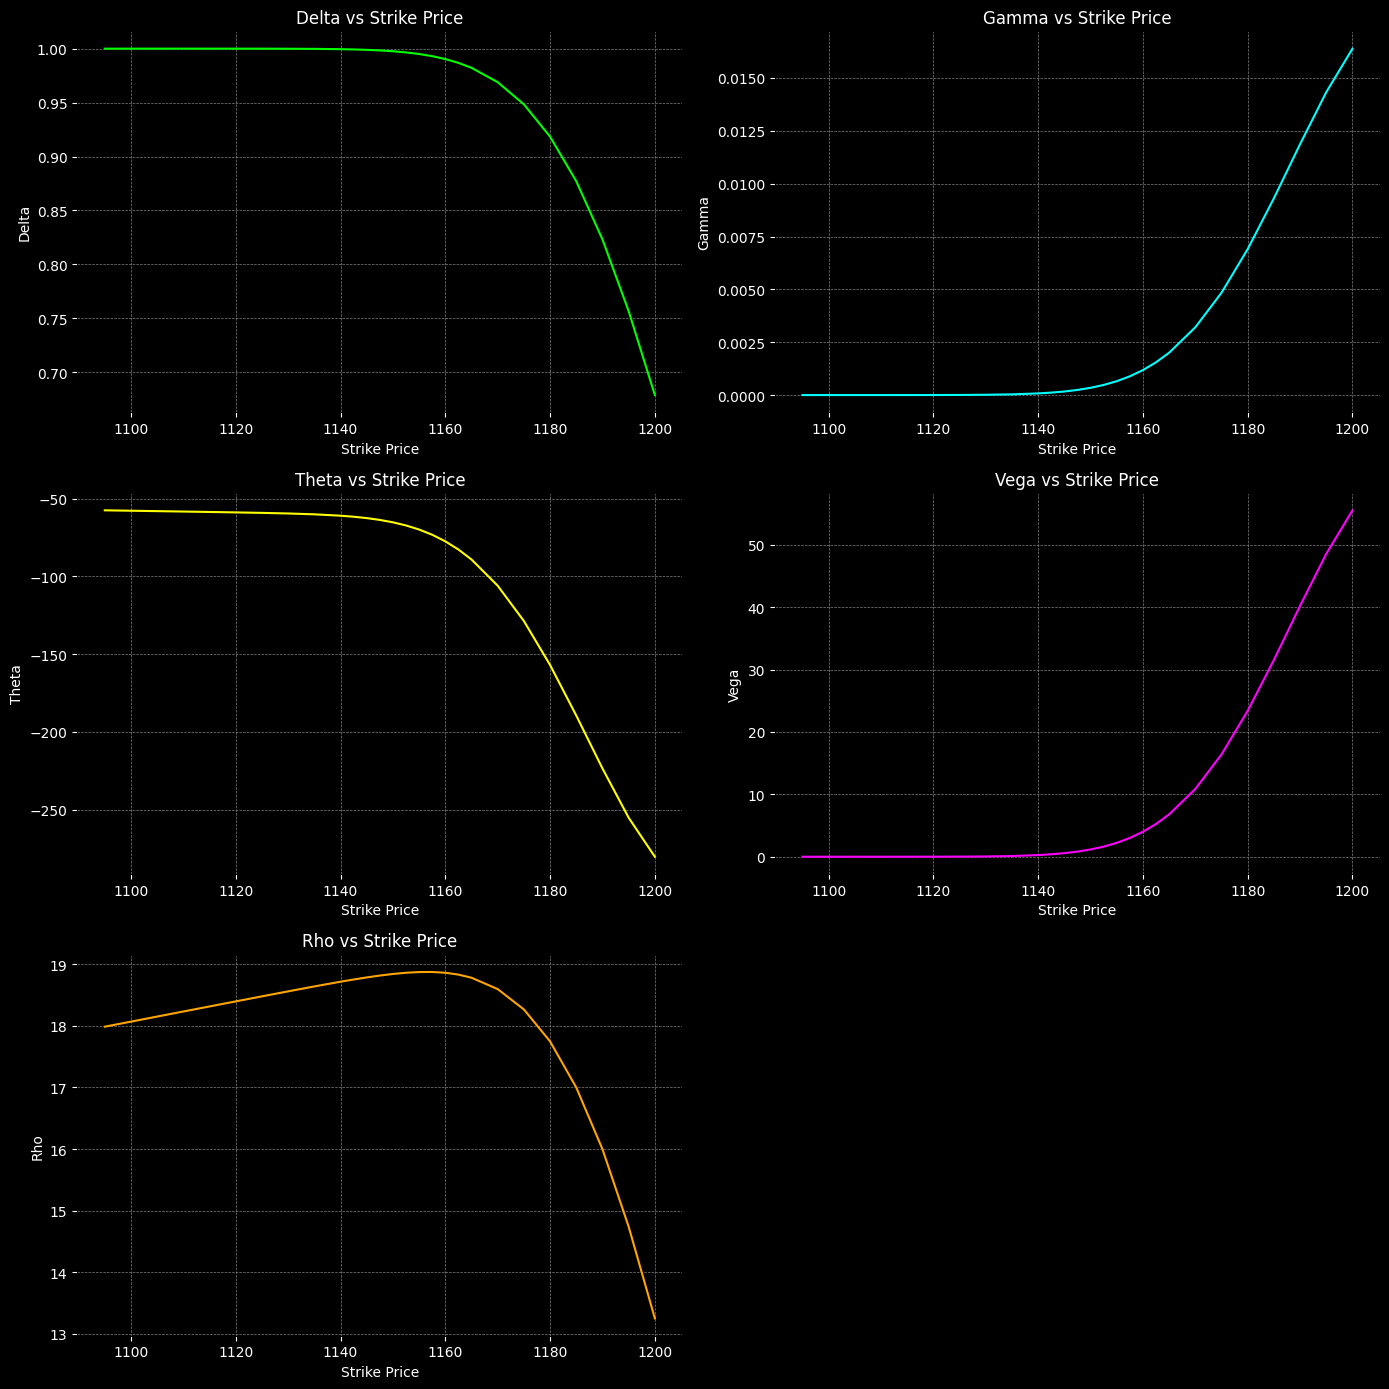

In [19]:
plot_greeks(call_option)